# Use VAEs to compress single target population dynamics (OD and fluorescence)

Author: Zhengqing Zhou
Updated: 2025/06/13

In [1]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.metrics import r2_score

import time as timer
import pickle

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)


'cuda:0'

# VAE Network
The VAE network has 32 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 168) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):

        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.T = 168
        self.channels = 32
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )
        
        self.mean_map = nn.Linear(self.channels*self.T, self.latent_dim)
        
        self.std_map = nn.Linear(self.channels*self.T, self.latent_dim)
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels*self.T),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var

def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."
    
    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha*KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train single FP dynamics with VAEs of 1 embedding

In [4]:
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch in data_loader:
        batch = batch.to("cuda:0")
        optimizer.zero_grad()
        pred, code, mu, log_var = model(batch)
        loss = vae_loss(pred, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to("cuda:0")
            pred, code, mu, log_var = model(batch)
            loss = vae_loss(pred, batch, mu, log_var)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [5]:
def get_data(target):
    idx_FP_map = {"EGFP":0, "mTagBFP2":1, "LSSmOrange":2, "mCherry":3, "OD":4}
    idx = idx_FP_map[target]
    X_train = np.load("Nano_target_dynamics_train.npy")[:,idx:idx+1,:]
    X_test = np.load("Nano_target_dynamics_test.npy")[:,idx:idx+1,:]
    return X_train, X_test

In [6]:
# set the random seed so the three trials have different initial model weights
torch.manual_seed(0)

lr = 1e-3
lr_decay = 0.99
batch_size = 16
EPOCHS = 200

n_target = 1
n_embedding = 1
target = "OD"
X_train, X_test = get_data(target)
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()
train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(X_test,batch_size=batch_size,shuffle=False)

model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.train()
print("model parameters: %1.1e"%count_parameters(model))
train_losses=[]
test_losses=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for ix_epoch in trange(EPOCHS):
    train_err=train_model(model, train_loader, optimizer)
    test_err=test_model(model, test_loader)
    train_losses.append(train_err)
    test_losses.append(test_err)
    # Exponential decay for learning rate
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
print("training finished, with starting MSE %1.1e, and ending error %1.1e"%(test_losses[0],test_losses[-1]))
torch.save(model.state_dict(), f"./vae_models/{target}_E1.pth")

model parameters: 3.4e+04


  0%|          | 0/200 [00:00<?, ?it/s]

training finished, with starting MSE 8.0e-03, and ending error 1.8e-03


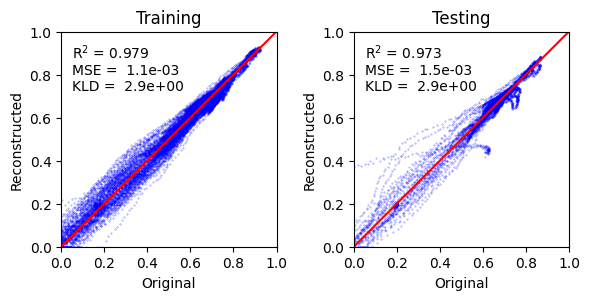

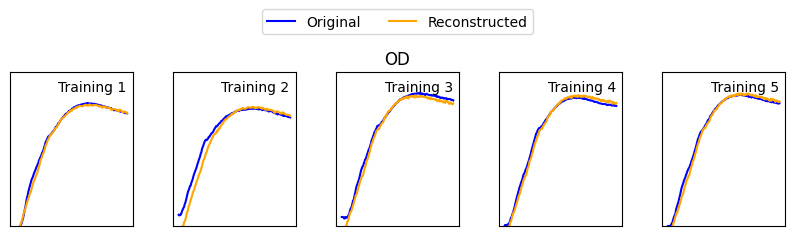

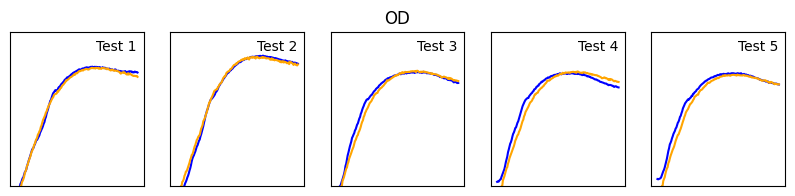

In [8]:
target="OD"
n_target=1
n_embedding=1
model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.load_state_dict(
    torch.load(
        f"./vae_models/{target}_E1.pth",
        weights_only=True
    )
)
X_train, X_test = get_data(target)
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum

test_data=torch.Tensor(X_test)
sums = test_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, _, mu_train, logvar_train = model(train_data.to(device))
    output_test, _, mu_test, logvar_test = model(test_data.to(device))


output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.2
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
KLD_train = -0.5 * torch.mean(1 + logvar_train - mu_train.pow(2) - logvar_train.exp())
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}\nKLD = {KLD_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
KLD_test = -0.5 * torch.mean(1 + logvar_test - mu_test.pow(2) - logvar_test.exp())
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}\nKLD = {KLD_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
# Training data trajectories
idx_show = np.random.choice(ranked_indices_train[0:50],5,replace=False)
for i,idx in enumerate(idx_show):
    axs[i].plot(train_data[idx,0], color='blue')
    axs[i].plot(output_train[idx,0], color='orange')
    axs[i].set_ylim([0,1])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[i].transAxes)
axs[2].set_title(target)
axs[2].plot([], label='Original', color='blue')
axs[2].plot([], label='Reconstructed', color='orange')
axs[2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
fig.subplots_adjust(hspace=0.25,wspace=0.33)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
# Testing data trajectories
idx_show = np.random.choice(ranked_indices_test[0:50],5,replace=False)
for i,idx in enumerate(idx_show):
    axs[i].plot(test_data[idx,0], color='blue')
    axs[i].plot(output_test[idx,0], color='orange')
    axs[i].set_ylim([0,1])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[i].transAxes)
axs[2].set_title(target)
plt.show()


# Infer the growth dynamics based on endpoint fluorescence

In [9]:
class MLP_VAE(torch.nn.Module):
    
    def __init__(self, VAE, n_embedding, N):
        super().__init__()
        
        self.channels = 256
        
        self.mlp = nn.Sequential(
            nn.Linear(N,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels,n_embedding),
            nn.LeakyReLU(),
        )

        self.fc_decoder = VAE.fc_decoder.eval()
        self.decoder = VAE.decoder.eval()
        
        # Freeze the parameters of the VAE
        for param in self.fc_decoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
        
    
    def forward(self, X):

        B = X.shape[0]
        C = 32
        L = 168
        
        code = self.mlp(X)
        
        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat


In [10]:
class ABDCurvesDataSet(torch.utils.data.Dataset):
    
    def __init__(self, abd, curves):
        
        self.X = abd
        self.Y = curves
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.Y[idx]

def get_abd_ts_data(target):
    idx_FP_map = {"EGFP":0, "mTagBFP2":1, "LSSmOrange":2, "mCherry":3, "OD":4} # correspondence between the FP and their position in the time series data
    
    id_FP = idx_FP_map[target]
    Y = np.load("./sequenced_data/sequenced_target_normal.npy")[:,id_FP:id_FP+1,:]

    composition = np.loadtxt("./sequenced_data/sequence_composition.txt")
    donor_abd = composition[:, 0:4]

    donor_abd = donor_abd / np.max(donor_abd, axis=0)

    Y = torch.Tensor(Y).float()
    donor_abd = torch.Tensor(donor_abd[:,np.newaxis]).float()

    full_dataset = ABDCurvesDataSet(donor_abd,Y)
    return full_dataset

In [11]:
#train and test function for mlp
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.mlp.train()

    for abd, curves in data_loader:
        abd = abd.to(device)
        curves = curves.to(device)
        
        optimizer.zero_grad()
        pred = model(abd)
        loss = F.mse_loss(pred, curves)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.mlp.eval()
    with torch.no_grad():
        for abd, curves in data_loader:
            abd = abd.to(device)
            curves = curves.to(device)
            pred = model(abd)
            loss = F.mse_loss(pred, curves)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [12]:
from sklearn.model_selection import StratifiedKFold
def run_cross_validation_growth(target,trial):
    seed = trial*42

    lr_0 = 3e-4

    EPOCHS = 100
    lr_decay = 0.99
    batch_size = 16

    n_embedding = 1
    n_target = 1
    # Load pretrained VAE
    vae_model = VAE(n_target, n_embedding)
    vae_model.load_state_dict(
        torch.load(
            f"./vae_models/{target}_E1.pth",
            weights_only=True
        )
    )
    vae_model.to("cuda:0")
    vae_model.eval()

    full_dataset = get_abd_ts_data(target)

    all_train_losses = []
    all_test_losses = []

    # stratified 10-fold CV based on maximum FP reading
    k_folds = 10
    y_np = full_dataset.Y.numpy()
    y_cont = np.max(y_np, axis=(1, 2))  # 1-D numpy array or list
    n_bins = 5  # 5 quantile bins  →  roughly equal counts
    bins = np.quantile(y_cont, np.linspace(0, 1, n_bins + 1))
    y_bins = np.digitize(y_cont, bins[1:-1])

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

    for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(y_bins)), y_bins)):
        torch.manual_seed(seed+fold)
        lr = lr_0 * 1

        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        test_subset = torch.utils.data.Subset(full_dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        mlpvae = MLP_VAE(vae_model, n_embedding, 4).float().to(device)
        # print("MLP-VAE model parameters = %1.1e" % count_parameters(mlpvae))
        mlpvae.mlp.train()

        optimizer = torch.optim.Adam(mlpvae.mlp.parameters(), lr=lr)
        train_losses = []
        test_losses = []

        test_err = test_model(mlpvae, test_loader)
        # print(f"Initial test loss: {test_err:.2e}")

        for ix_epoch in trange(EPOCHS):
            train_err = train_model(mlpvae, train_loader, optimizer)
            test_err = test_model(mlpvae, test_loader)
            train_losses.append(train_err)
            test_losses.append(test_err)
            # Exponential decay for learning rate
            lr *= lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)

        #torch.save(mlpvae.state_dict(), f"./mlp_models/{target}/{target}_growth_curve_inference_{fold + 1}-fold_trial{trial}.pth")

    return all_train_losses, all_test_losses

In [13]:
import time as timer
t0=timer.perf_counter()
target="LSSmOrange"
train_losses, test_losses = run_cross_validation_growth(target,trial=1)
train_time=timer.perf_counter()-t0
print("training finished, time used: %i s"%train_time)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

training finished, time used: 49 s


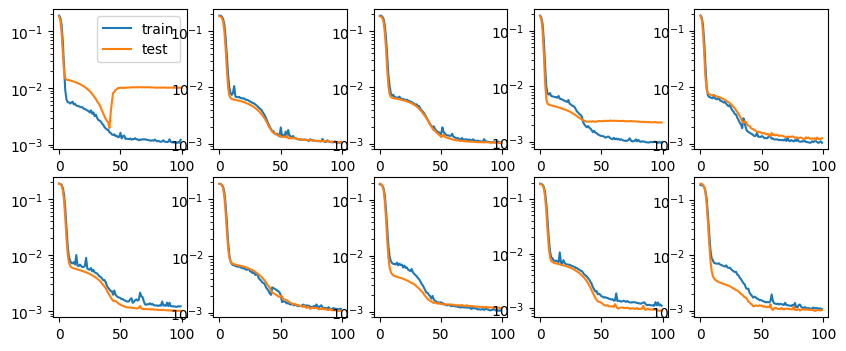

In [14]:
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
for i in range(10):
    ax=axes[i]
    ax.plot(train_losses[i],label="train")
    ax.plot(test_losses[i],label="test")
    ax.set_yscale("log")
axes[0].legend()
plt.show()

## Evaluate model performance (R2) on per-fold basis
**below this point, evaluation of the MLP inference of mCherry (trial 1) can be performed, but the evaluation of the other three fluorescence proteins requires downloading the entire dataset from Zenodo.**

In [17]:
from sklearn.metrics import r2_score
import numpy as np
import torch
from pathlib import Path

device      = "cuda:0"
n_target    = 1
n_embedding = 1
target      = "mCherry"

# ------------------------------------------------------------------
# one-time setup
vae_path   = f"./vae_models/{target}_E1.pth"
vae_model  = VAE(n_target, n_embedding)
vae_model.load_state_dict(torch.load(vae_path, weights_only=True))
vae_model.eval().to(device)

full_dataset = get_abd_ts_data(target)
y_np         = full_dataset.Y.numpy()                     # (N, C, T)
y_cont       = np.max(y_np, axis=(1, 2))
bins         = np.quantile(y_cont, np.linspace(0, 1, 6))
y_bins       = np.digitize(y_cont, bins[1:-1])

# ------------------------------------------------------------------
# containers for the 10 × 10 matrix  ⚡
r2_matrix = np.zeros((10, 10), dtype=np.float32)          # trials × folds

trial = 1
seed   = trial * 42
skf    = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(y_bins)), y_bins)):

    # ---------- inference on this fold ----------
    X_test = torch.stack([full_dataset[i][0] for i in test_idx])
    y_test = torch.stack([full_dataset[i][1] for i in test_idx])

    mlpvae = MLP_VAE(vae_model, n_embedding, 4).float().to(device)
    ckpt   = f"./mlp_models/{target}/{target}_growth_curve_inference_{fold+1}-fold_trial{trial}.pth"
    mlpvae.load_state_dict(torch.load(ckpt, weights_only=True))
    mlpvae.eval()

    with torch.no_grad():
        y_pred = mlpvae(X_test.to(device)).cpu()

    # ---------- R² for *this* fold  ⚡ ----------
    r2_fold = r2_score(y_test.flatten().numpy(), y_pred.flatten().numpy())
    r2_matrix[trial - 1, fold] = r2_fold        # row = trial-1, col = fold

print(f"trial {trial:2d} — mean-fold R² = {r2_matrix[trial-1].mean():.3f} "
      f"(±{r2_matrix[trial-1].std(ddof=1):.3f} SD)")

# ------------------------------------------------------------------
# save & inspect  ⚡
# save_dir = Path(f"./saved_data/growth_curves")
# save_dir.mkdir(parents=True, exist_ok=True)
# np.save(save_dir / f"{target}_r2_per_fold_trials.npy", r2_matrix)

print("\nR² per fold (rows = trials, cols = folds 1-10):")
print(np.array2string(r2_matrix, precision=3, floatmode='fixed'))


trial  1 — mean-fold R² = 0.861 (±0.077 SD)

R² per fold (rows = trials, cols = folds 1-10):
[[0.838 0.863 0.854 0.921 0.664 0.905 0.860 0.942 0.909 0.852]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]


## Save the inferred time series of FPs

In [18]:
from sklearn.model_selection import StratifiedKFold

device = "cuda:0"
n_target = 1
n_embedding = 1
target = "mCherry"

# Load VAE model
vae_path = f"./vae_models/{target}_E1.pth"
vae_model = VAE(n_target, n_embedding)
vae_model.load_state_dict(torch.load(vae_path, weights_only=True))
vae_model.eval()
vae_model.to(device)

full_dataset = get_abd_ts_data(target)
y_np = full_dataset.Y.numpy()
np.save(f"./saved_data/growth_curves/{target}/{target}_ground_truth.npy",y_np)
y_cont = np.max(y_np,axis=(1,2))            # 1-D numpy array or list
n_bins  = 5                        # 5 quantile bins  →  roughly equal counts
bins    = np.quantile(y_cont, np.linspace(0, 1, n_bins + 1))
y_bins  = np.digitize(y_cont, bins[1:-1])

trial = 1
seed = trial*42

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

ground_truth = np.zeros_like(y_np)
prediction = np.zeros_like(y_np)
for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(y_bins)), y_bins)):

    # Create test subset and loader
    X_test = torch.stack([full_dataset[i][0] for i in test_idx])
    y_test = torch.stack([full_dataset[i][1] for i in test_idx])

    # Load MLP-VAE model
    mlpvae = MLP_VAE(vae_model, n_embedding, 4).float().to(device)
    model_path = f"./mlp_models/{target}/{target}_growth_curve_inference_{fold+1}-fold_trial{trial}.pth"
    mlpvae.load_state_dict(torch.load(model_path, weights_only=True))
    mlpvae.eval()

    with torch.no_grad():
        y_pred = mlpvae(X_test.to(device)).cpu()

    ground_truth[test_idx,:,:]=y_test.numpy()
    prediction[test_idx,:,:]=y_pred.numpy()
r2 = r2_score(y_np.flatten(),prediction.flatten())
#np.save(f"./saved_data/growth_curves/{target}/{target}_inference_trial{trial}.npy",prediction)
print(f"{target} inference trial {trial} evaluation finished, global R2 = {r2:.3f}")
print(f"MLP model parameters: {count_parameters(mlpvae):1.2e}")

mCherry inference trial 1 evaluation finished, global R2 = 0.848
MLP model parameters: 1.33e+05


## Visualize the inference quality

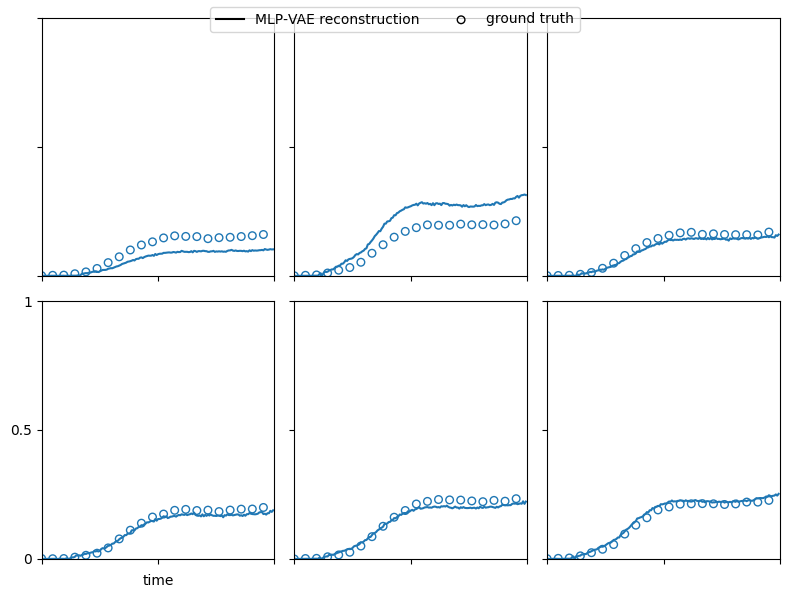

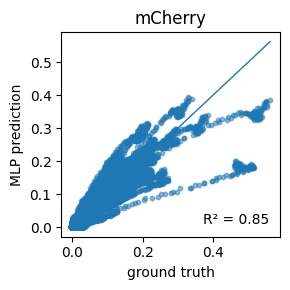

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score

# ------------------------------------------------------------------
# CONFIG ------------------------------------------------------------
trial = 1                                     # visualise trial 1
base_dir = Path("./saved_data/growth_curves")    # data location
np.random.seed(42)

# ------------------------------------------------------------------
# LOAD DATA ---------------------------------------------------------

target = "mCherry"
gt_path   = base_dir / target / f"{target}_ground_truth.npy"
pred_path = base_dir / target / f"{target}_inference_trial{trial}.npy"

truth = np.load(gt_path)
pred  = np.load(pred_path)

# ------------------------------------------------------------------
# FIGURE 1: Six example wells --------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes = axes.flat

n_show   = 6
tp_show  = np.arange(0, 168, 8)  # mark every 8th time‑point
x        = np.arange(0, 168, 1)

# rank samples by total signal per FP curve
SUM = np.sum(truth, axis=(1, 2))
rank_indices = np.argsort(SUM)[::-1]             # descending
idx_show = np.random.choice(rank_indices[:30], n_show, replace=False)

for i, ii in enumerate(idx_show):
    ax = axes[i]
    data = truth[ii,0]     # shape (C_total, T)
    rec  = pred[ii,0]
    l = ax.plot(x, rec, linewidth=1.5)
    ax.scatter(x[tp_show], data[tp_show],
               s=30, edgecolor=l[-1].get_color(), facecolor="None")

    ax.set_ylim([0, 1])
    ax.set_xlim([0, 168])
    ax.set_xticks([0, 84, 168])
    ax.set_xticklabels([])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

# shared legend
axes[3].set_xlabel("time")
axes[3].set_yticklabels([0, 0.5, 1])
axes[3].plot([], [], linewidth=1.5, color="k", label="MLP‑VAE reconstruction")
axes[3].scatter([], [], s=30, edgecolor="k", facecolor="None", label="ground truth")
fig.legend(loc="upper center", ncol=2)
fig.tight_layout()

# ------------------------------------------------------------------
# FIGURE 2: Scatter plot --------------------------------
fig2, ax2 = plt.subplots(1, 1, figsize=(3, 3))

ground_truth = truth[:, 0, :].flatten()
pred         = pred[:, 0, :].flatten()

ax2.scatter(ground_truth, pred, s=10, alpha=0.5)
diag_max = np.max(ground_truth)
ax2.plot([0, diag_max], [0, diag_max], lw=1)

r2 = r2_score(ground_truth, pred)
ax2.set_title(target)
ax2.text(0.95, 0.05, f"R² = {r2:.2f}", transform=ax2.transAxes,
         ha="right", va="bottom")

ax2.set_xlabel("ground truth")
ax2.set_ylabel("MLP prediction")
fig2.tight_layout()

plt.show()
